0. All libraries are loaded for the execution.


In [ ]:
!pip install shap
!pip install fitter
!pip install distfit

In [ ]:
#https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Dropout
from keras.regularizers import l2,L1,L1L2
from keras.callbacks import EarlyStopping
from scipy.stats import skew

#To upload the file automatically
from google.colab import drive

#Neural Networks Libraries
from keras.models import Sequential
from keras.layers import Dense, Reshape
from sklearn.model_selection import train_test_split
import tensorflow as tf

#Clustering Process
from sklearn.cluster import KMeans

#Credibility Surfaces
from matplotlib import cm
import seaborn as sns

#characterisation of probability distributions
from scipy import stats
from distfit import distfit
from fitter import Fitter,get_common_distributions,get_distributions


1.1 Methods for model configuration

In [ ]:
def metricas_desempeno(LDAio,LDAor):

  from scipy.stats import skew
  #Estimating Performance Matrices
  #1. Fractional Bias
  FB=(np.mean(LDAio)-np.mean(LDAor))/(0.5*(np.mean(LDAio)+np.mean(LDAor)))

  #2. Normalized Mean Square Error
  NMSE=((np.mean(LDAio-LDAor))**2)/(np.mean(LDAio)*np.mean(LDAor))
  #NMSE=np.var(LDAio-LDAor)/np.var(LDAio)
  #plt.figure()
  #plt.scatter(LDAio,LDAor)
  #plt.show()

  #3. Geometric Mean Bias
  MG=np.exp(np.mean(np.log(LDAio+1))-np.mean(np.log(LDAor+1)))

  #4. Geometric Variance Bias
  VG=np.exp(np.mean((np.log(LDAio+1)-np.log(LDAor+1))**2))

  #5. FAC2
  FAC2=0
  for i in range(len(LDAio)):
    if ((LDAio[i,]/LDAor[i,])>0.8):
      if((LDAio[i,]/LDAor[i,])<1.2):
        FAC2=FAC2+1
  FAC2=FAC2/len(LDAio)

  #6.IOA
  IOA=np.corrcoef(LDAio,LDAor)[0,0]

  #7. UAPC2
  UAPC2=np.abs((np.max(LDAio)-np.max(LDAor))/np.max(LDAio))

  #8. MRE
  MRE=np.mean(np.abs(((LDAio+1)-(LDAor+1))/(LDAio+1)))

  #9. Skewness Index
  skwio=skew(LDAio);skwor=skew(LDAor)

  return FB,NMSE,MG,VG,FAC2,UAPC2,IOA,MRE,skwio,skwor

1.2 Synthesising the model

In [ ]:
#Obtaining the information structure the model.
def datosmodel(model):

  W0=np.array(model.layers[0].get_weights()[0])
  W1=np.array(model.layers[2].get_weights()[0])
  W2=np.array(model.layers[4].get_weights()[0])
  W3=np.array(model.layers[6].get_weights()[0])

  MCfo=np.array(W3[:,0]).reshape(5,5);sigmafo=np.std(MCfo)
  MCfe=np.array(W3[:,2]).reshape(5,5);sigmafe=np.std(MCfe)
  MCso=np.array(W3[:,1]).reshape(5,5);sigmaso=np.std(MCso)
  MCse=np.array(W3[:,3]).reshape(5,5);sigmase=np.std(MCse)

  WCDf=np.zeros((5,5)); WCDs=np.zeros((5,5)); WC=np.zeros((5,5))

  #Se procede a calcular la matriz de credibilidad
  for i in range(5):
    for j in range(5):
      dem=(nXCo[i,]*sigmafo+nYCe[j,]*sigmafe)/(nXCo[i,]+nYCe[j,])
      WCDf[i,j]=np.exp(-1*((MCfo[i,j]-MCfe[i,j])/dem)**2)
      dem=(nXCo[i,]*sigmaso+nYCe[j,]*sigmase)/(nXCo[i,]+nYCe[j,])
      WCDs[i,j]=np.exp(-1*((MCso[i,j]-MCse[i,j])/dem)**2)
      WC[i,j]=WCDf[i,j]*WCDs[i,j]

  # Crear un array de ejemplo
  data = WC

  return WC,W0,W1,W2,W3

1.2 Credibility Matrices

In [ ]:
def MatrixCred(XD):

  #1. Observed Credibility Matrix
  nWCo=np.zeros((5,5));mWCo=np.zeros((5,5));vWCo=np.zeros((5,5))
  XfCo=np.zeros((5,1)); XsCo=np.zeros((5,1))

  kmeans = KMeans(n_clusters=5)
  kmeans.fit(XD[:,0].reshape(-1,1))
  XfCo=kmeans.cluster_centers_;XfCo=np.array(sorted(XfCo)).reshape(5,1)

  kmeans = KMeans(n_clusters=5)
  kmeans.fit(XD[:,1].reshape(-1,1))
  XsCo=kmeans.cluster_centers_;XsCo=np.array(sorted(XsCo)).reshape(5,1)

  #2. Counting of Data
  for k in range(len(XD[:,0])):
    mf=-1; dmf=np.zeros((5,1)); dms=np.zeros((5,1))
    dfm=np.abs(XfCo-XD[k,0])
    fo=np.where(np.min(dfm)==dfm)[0]
    dsm=np.abs(XsCo-XD[k,1])
    co=np.where(np.min(dsm)==dsm)[0]
    nWCo[fo,co]=nWCo[fo,co]+1
    mWCo[fo,co]=mWCo[fo,co]+XD[k,0]*XD[k,1]

  mWCo=mWCo/nWCo

  #3. Variance Estimation
  for k in range(len(XD[:,0])):
    mf=-1; dmf=np.zeros((5,1)); dms=np.zeros((5,1))
    dfm=np.abs(XfCo-XD[k,0])
    fo=np.where(np.min(dfm)==dfm)[0]
    dsm=np.abs(XsCo-XD[k,1])
    co=np.where(np.min(dsm)==dsm)[0]
    vWCo[fo,co]=vWCo[fo,co]+(mWCo[fo,co]-(XD[k,0]*XD[k,1]))**2

  vWCo=vWCo/nWCo

  return nWCo,mWCo,vWCo

1.3 Credibility Surface

In [ ]:
def SupCred(WC,XCo,nXCo,YCe,nYCe):

  #1. MeshGrid Limits
  x=np.linspace(-1,11, num=100)
  y=np.linspace(-1,11, num=100)

  #xldai=(XDI[:,0]*XDI[:,1]);xldae=(XDE[:,0]*XDE[:,1])
  xo=sorted(XCo); xo=(10/(np.max(xo)-np.min(xo)))*(xo-np.min(xo))
  yo=sorted(YCe); yo=(10/(np.max(yo)-np.min(yo)))*(yo-np.min(yo))

  #2. MeshGrid of Reference
  x, y = np.meshgrid(x, y)
  z=np.zeros((100,100,25))
  zt=np.zeros((100,100))

  m1=-1;znum=0;zden=0
  for i in range(5):
    for j in range(5):
      m1=m1+1
      fc=1-WC[i,j]
      zt=zt+(fc*XCo[i,]+(1-fc)*YCe[j,])*np.exp(-0.5*(x-xo[i,])**2-1.0*(y-yo[j,])**2)
      znum=znum+(fc*XCo[i,]*nXCo[i,]+(1-fc)*YCe[j,]*nYCe[j,])
      zden=zden+(XCo[i,]*nXCo[i,]+YCe[j,]*nYCe[j,])

  #3. Caractrization LDA (Loss Distribution Approach)
  zfc=(znum/zden);
  ztOpVar=zfc*np.percentile(LDAo.flatten(),99.9)+(1-zfc)*np.percentile(LDAe.flatten(),99.9)

  return zt, zfc,x,y

2. Implementation of the Autoencoder Neural Model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1000)              4000      
                                                                 
 dropout_12 (Dropout)        (None, 1000)              0         
                                                                 
 dense_17 (Dense)            (None, 500)               500000    
                                                                 
 dropout_13 (Dropout)        (None, 500)               0         
                                                                 
 dense_18 (Dense)            (None, 25)                12500     
                                                                 
 dropout_14 (Dropout)        (None, 25)                

<Figure size 800x600 with 0 Axes>

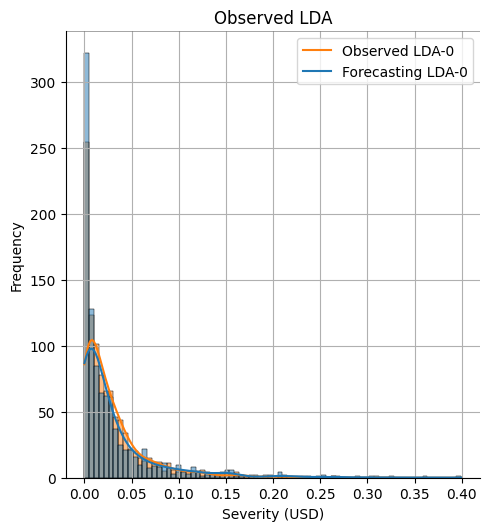

<Figure size 800x600 with 0 Axes>

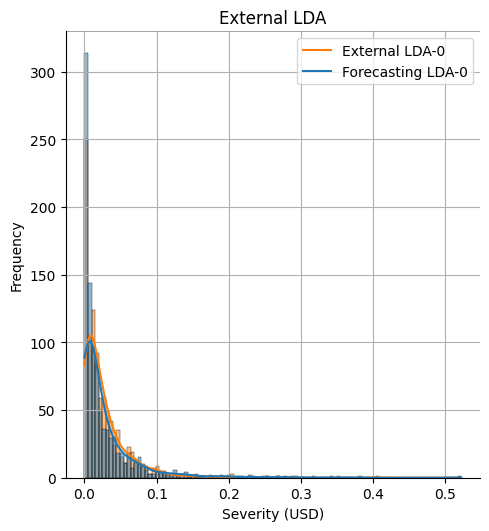

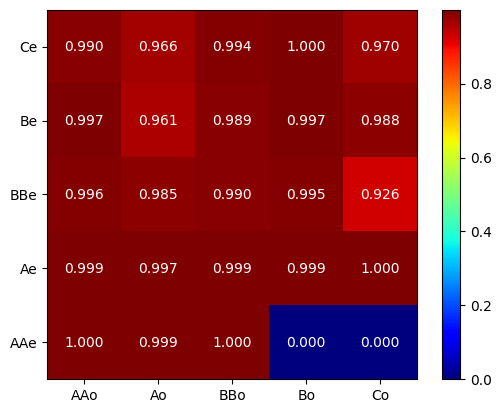

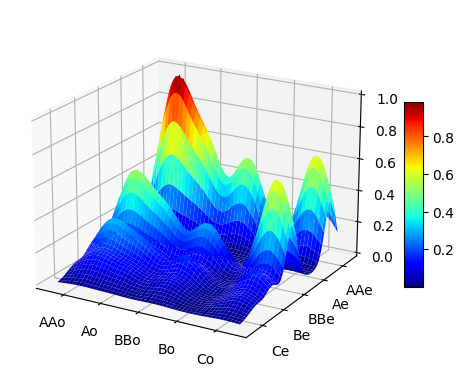

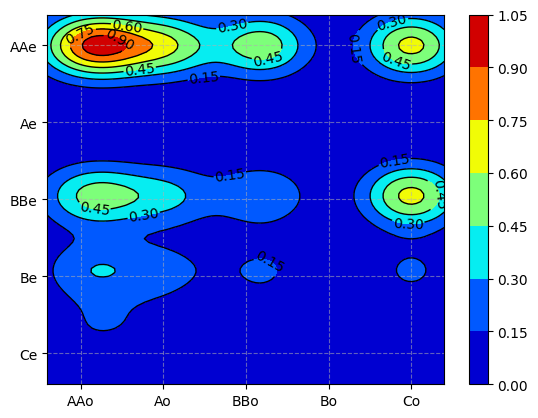

<Figure size 800x600 with 0 Axes>

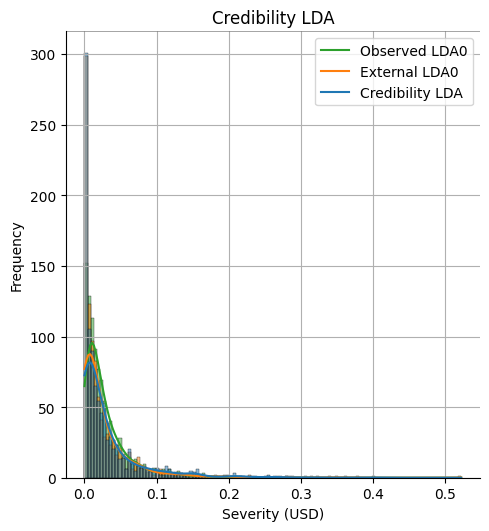

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.00 sec] [RSS: 2597.14] [loc=0.030 scale=0.047]
[distfit] >INFO> [expon     ] [0.00 sec] [RSS: 706.045] [loc=0.000 scale=0.030]
[distfit] >INFO> [pareto    ] [0.00 sec] [RSS: 53.6725] [loc=-0.012 scale=0.012]
[distfit] >INFO> [dweibull  ] [0.05 sec] [RSS: 1292.44] [loc=0.008 scale=0.023]
[distfit] >INFO> [t         ] [0.13 sec] [RSS: 1209.55] [loc=0.010 scale=0.012]
[distfit] >INFO> [genextreme] [0.24 sec] [RSS: 2179.38] [loc=0.002 scale=0.012]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 2745.87] [loc=-0.000 scale=0.867]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 3931.6] [loc=-0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 89.6812] [loc=-0.000 scale=7.718]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 3599.24] [loc=0.000 scale=0.399]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 2611.53] [loc=-18.197 scale=2.345]
[distfit] >INFO> [norm      ] [0.85 sec] [RSS: 2597.14] [loc=0.030 

Observed Input:            name        score        loc     scale  \
0       pareto    53.672498  -0.012098  0.012098   
1         beta    89.681233       -0.0  7.718392   
2        expon   706.045264        0.0  0.030245   
3            t  1209.545934   0.010019  0.011817   
4     dweibull  1292.444507   0.007546  0.022577   
5   genextreme  2179.383988   0.001683   0.01243   
6         norm  2597.142794   0.030245  0.047302   
7     loggamma  2611.525103 -18.196686  2.345031   
8        gamma  2745.874283       -0.0  0.866672   
9      uniform   3599.24279        0.0  0.399374   
10     lognorm  3931.595937       -0.0       0.0   

                                         arg  \
0                      (1.1323508904228359,)   
1   (0.6827801629029444, 286.16110597584185)   
2                                         ()   
3                       (1.187401770997527,)   
4                      (0.7349567166114306,)   
5                      (-7.383674622434597,)   
6                     

[distfit] >INFO> [t         ] [0.14 sec] [RSS: 1055.64] [loc=0.015 scale=0.015]
[distfit] >INFO> [genextreme] [0.14 sec] [RSS: 115.616] [loc=0.008 scale=0.011]
[distfit] >INFO> [gamma     ] [0.08 sec] [RSS: 77.0612] [loc=0.000 scale=0.044]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 119.284] [loc=-0.000 scale=0.012]
[distfit] >INFO> [beta      ] [0.10 sec] [RSS: 86.7878] [loc=0.000 scale=2.459]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2838.15] [loc=0.000 scale=0.312]
[distfit] >INFO> [loggamma  ] [0.07 sec] [RSS: 1726.65] [loc=-12.832 scale=1.705]
[distfit] >INFO> [norm      ] [0.68 sec] [RSS: 1702.21] [loc=0.029 scale=0.038]
[distfit] >INFO> [expon     ] [0.68 sec] [RSS: 268.109] [loc=0.000 scale=0.029]
[distfit] >INFO> [pareto    ] [0.68 sec] [RSS: 81.8536] [loc=-0.059 scale=0.059]
[distfit] >INFO> [dweibull  ] [0.67 sec] [RSS: 1245.38] [loc=0.015 scale=0.022]
[distfit] >INFO> [t         ] [0.58 sec] [RSS: 1055.64] [loc=0.015 scale=0.015]
[distfit] >INFO> [genextreme] [0.44 

Observed Output:            name        score        loc     scale  \
0        gamma    77.061222   0.000012    0.0436   
1       pareto    81.853642  -0.058533  0.058546   
2         beta    86.787765   0.000012  2.458943   
3   genextreme   115.615957   0.008424  0.011214   
4      lognorm   119.283828  -0.000277  0.012281   
5        expon   268.108744   0.000012  0.029058   
6            t  1055.642874   0.015494  0.015069   
7     dweibull  1245.376206   0.014873  0.021608   
8         norm  1702.207558   0.029071  0.037602   
9     loggamma  1726.654882 -12.831889  1.705365   
10     uniform  2838.150103   0.000012   0.31184   

                                       arg  \
0                     (0.656156092555815,)   
1                    (2.9462654248149986,)   
2   (0.621146222459266, 51.27265646932003)   
3                   (-0.8537566893269541,)   
4                    (1.5625653204495211,)   
5                                       ()   
6                    (1.72180135528

[distfit] >INFO> [t         ] [0.14 sec] [RSS: 1294.66] [loc=0.009 scale=0.010]
[distfit] >INFO> [genextreme] [0.29 sec] [RSS: 2768.61] [loc=0.002 scale=0.016]
[distfit] >INFO> [gamma     ] [0.13 sec] [RSS: 2417.74] [loc=-0.000 scale=1.207]
[distfit] >INFO> [lognorm   ] [0.08 sec] [RSS: 4712.76] [loc=-0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.12 sec] [RSS: 89.4533] [loc=-0.000 scale=7.061]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 4454.91] [loc=0.000 scale=0.522]
[distfit] >INFO> [loggamma  ] [0.08 sec] [RSS: 3190.09] [loc=-11.496 scale=1.632]
[distfit] >INFO> [norm      ] [0.98 sec] [RSS: 3155.17] [loc=0.028 scale=0.046]
[distfit] >INFO> [expon     ] [0.98 sec] [RSS: 809.514] [loc=0.000 scale=0.028]
[distfit] >INFO> [pareto    ] [0.98 sec] [RSS: 57.9421] [loc=-0.013 scale=0.013]
[distfit] >INFO> [dweibull  ] [0.97 sec] [RSS: 1314.27] [loc=0.006 scale=0.019]
[distfit] >INFO> [t         ] [0.89 sec] [RSS: 1294.66] [loc=0.009 scale=0.010]
[distfit] >INFO> [genextreme] [0.7

External Input:            name        score        loc     scale  \
0       pareto    57.942108  -0.013137  0.013137   
1         beta    89.453297       -0.0  7.060659   
2        expon   809.513522        0.0  0.027519   
3            t  1294.657703   0.008849  0.010002   
4     dweibull  1314.273605   0.006242  0.018657   
5        gamma  2417.744826       -0.0  1.207019   
6   genextreme  2768.611552   0.002029  0.016323   
7         norm  3155.171507   0.027519  0.046385   
8     loggamma  3190.091461 -11.495595  1.632192   
9      uniform  4454.913341        0.0   0.52179   
10     lognorm  4712.761605       -0.0       0.0   

                                        arg  \
0                     (1.2515599213585589,)   
1   (0.6297694390610453, 358.7286198947568)   
2                                        ()   
3                      (1.139459556576037,)   
4                     (0.7121880673228109,)   
5                     (0.3493868005546893,)   
6                     (-8.046

[distfit] >INFO> [t         ] [0.17 sec] [RSS: 1019.41] [loc=0.015 scale=0.014]
[distfit] >INFO> [genextreme] [0.06 sec] [RSS: 153.223] [loc=0.009 scale=0.011]
[distfit] >INFO> [gamma     ] [0.07 sec] [RSS: 286.659] [loc=0.000 scale=0.092]
[distfit] >INFO> [lognorm   ] [0.00 sec] [RSS: 110.701] [loc=-0.001 scale=0.014]
[distfit] >INFO> [beta      ] [0.16 sec] [RSS: 196.54] [loc=0.000 scale=0.954]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 3144.91] [loc=0.000 scale=0.404]
[distfit] >INFO> [loggamma  ] [0.11 sec] [RSS: 1795.58] [loc=-11.056 scale=1.513]
[distfit] >INFO> [norm      ] [0.73 sec] [RSS: 1755.16] [loc=0.028 scale=0.037]
[distfit] >INFO> [expon     ] [0.73 sec] [RSS: 228.88] [loc=0.000 scale=0.028]
[distfit] >INFO> [pareto    ] [0.73 sec] [RSS: 80.565] [loc=-0.071 scale=0.071]
[distfit] >INFO> [dweibull  ] [0.72 sec] [RSS: 1121.98] [loc=0.014 scale=0.019]
[distfit] >INFO> [t         ] [0.63 sec] [RSS: 1019.41] [loc=0.015 scale=0.014]
[distfit] >INFO> [genextreme] [0.46 sec

External Output:            name        score        loc     scale  \
0       pareto    80.564974  -0.070871  0.070882   
1      lognorm   110.701453  -0.000577  0.013591   
2   genextreme   153.223423   0.008867  0.011034   
3         beta   196.539944   0.000011  0.953912   
4        expon   228.879823   0.000011   0.02777   
5        gamma   286.659475   0.000011  0.092145   
6            t   1019.41311   0.014963  0.013879   
7     dweibull   1121.98044   0.013618  0.019458   
8         norm  1755.163064   0.027781   0.03675   
9     loggamma  1795.578714 -11.056074  1.513099   
10     uniform  3144.905844   0.000011  0.404323   

                                         arg  \
0                       (3.516706956095634,)   
1                      (1.3561198186164534,)   
2                     (-0.7685473455868121,)   
3   (0.9102765949242637, 29.832440279873317)   
4                                         ()   
5                     (0.31683415333300646,)   
6                    

[distfit] >INFO> [t         ] [0.19 sec] [RSS: 560.543] [loc=0.017 scale=0.014]
[distfit] >INFO> [genextreme] [0.15 sec] [RSS: 52.0502] [loc=0.012 scale=0.012]
[distfit] >INFO> [gamma     ] [0.13 sec] [RSS: 70.6175] [loc=-0.000 scale=0.035]
[distfit] >INFO> [lognorm   ] [0.16 sec] [RSS: 3051.78] [loc=-0.000 scale=0.000]
[distfit] >INFO> [beta      ] [0.22 sec] [RSS: 59.9836] [loc=-0.000 scale=506346906113.710]
[distfit] >INFO> [uniform   ] [0.00 sec] [RSS: 2563.08] [loc=0.000 scale=0.279]
[distfit] >INFO> [loggamma  ] [0.12 sec] [RSS: 1275.77] [loc=-13.488 scale=1.730]
[distfit] >INFO> [norm      ] [1.17 sec] [RSS: 1239.05] [loc=0.029 scale=0.033]
[distfit] >INFO> [expon     ] [1.17 sec] [RSS: 39.4996] [loc=0.000 scale=0.029]
[distfit] >INFO> [pareto    ] [1.16 sec] [RSS: 25.393] [loc=-0.165 scale=0.165]
[distfit] >INFO> [dweibull  ] [1.15 sec] [RSS: 684.68] [loc=0.016 scale=0.020]
[distfit] >INFO> [t         ] [1.04 sec] [RSS: 560.543] [loc=0.017 scale=0.014]
[distfit] >INFO> [genextr

Credibility LDA:            name        score        loc                scale  \
0       pareto    25.392973  -0.164674             0.164674   
1        expon    39.499619        0.0             0.028855   
2   genextreme    52.050169   0.011666             0.012415   
3         beta    59.983613  -0.000496  506346906113.709717   
4        gamma    70.617468       -0.0             0.034701   
5            t   560.543069   0.016734              0.01369   
6     dweibull    684.68049   0.016489              0.01968   
7         norm  1239.045225   0.028855             0.033448   
8     loggamma  1275.772857 -13.487968              1.72964   
9      uniform  2563.075409        0.0             0.279357   
10     lognorm  3051.782499       -0.0                  0.0   

                                         arg  \
0                       (6.698111064787397,)   
1                                         ()   
2                     (-0.5677684327975682,)   
3   (1.3358104251472138, 27776871

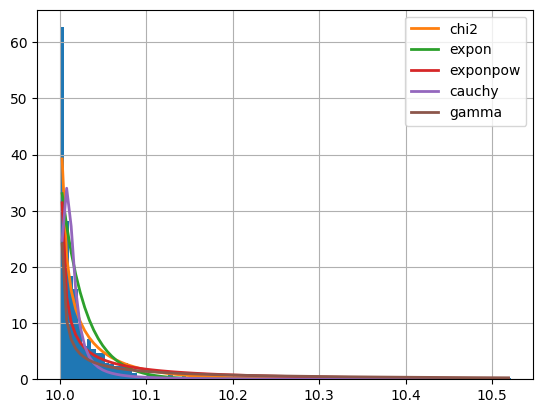

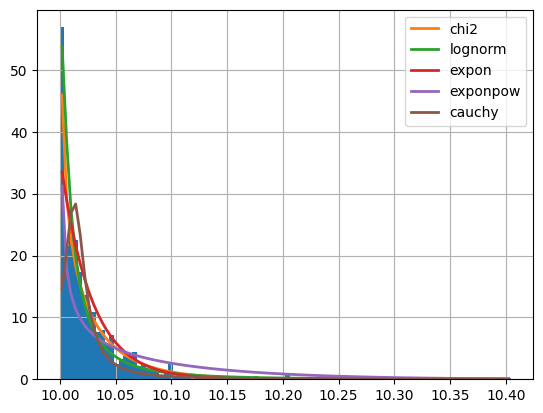

[          sumsquare_error          aic          bic  kl_div  ks_statistic  \
chi2           632.955219   445.073553   459.796819     inf      0.189000   
expon         1023.586157  1181.515763  1191.331274     inf      0.189000   
exponpow      1335.299396    95.476515   110.199781     inf      0.221757   
cauchy        1602.557404   493.769173   503.584683     inf      0.267498   
gamma         2122.801518    70.668870    85.392136     inf      0.338733   

              ks_pvalue  
chi2       9.436014e-32  
expon      9.435541e-32  
exponpow   1.127944e-43  
cauchy     1.138157e-63  
gamma     7.089464e-103  ,           sumsquare_error         aic         bic  kl_div  ks_statistic  \
chi2           224.582087  494.194124  508.917390     inf      0.032920   
lognorm        367.937350  236.866557  251.589823     inf      0.073910   
expon          655.027146  743.167708  752.983218     inf      0.100923   
exponpow      1096.726097   35.351484   50.074750     inf      0.253732   
cauc

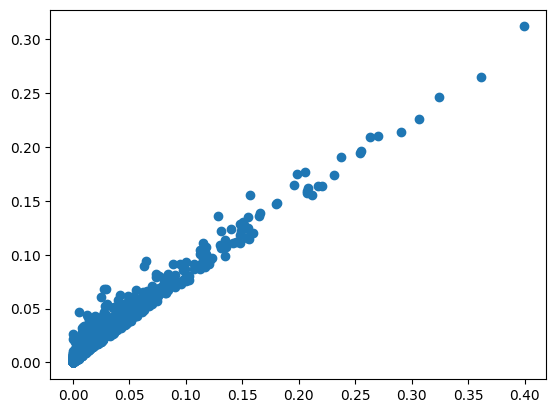

[distfit] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


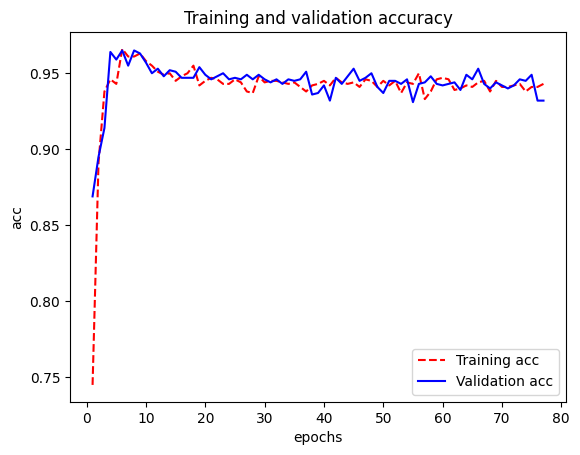

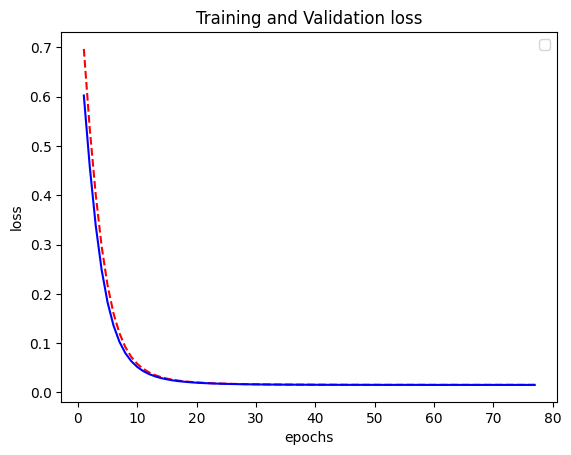

<Figure size 640x480 with 0 Axes>

In [ ]:
#Data Upload
drive.mount('/content/drive')
nxl='/content/drive/MyDrive/ASOC(2024)/0. DatosPrueba.xlsx'

#DataFrames
dfm2o=np.zeros((18,10))
dfm2e=np.zeros((18,10))
dfm2opv=np.zeros((18,7))
LDAiomn=np.zeros((1000,18)); LDAormn=np.zeros((1000,18))
LDAiemn=np.zeros((1000,18)); LDAermn=np.zeros((1000,18))
LDAztmn=np.zeros((1000,18))
NE=4

for im in range(1): #range(18):
  print(im)
  #Databases are taken
  XDBB=pd.read_excel(nxl,sheet_name=0)
  XDBI=pd.read_excel(nxl,sheet_name=1)
  XDBE=pd.read_excel(nxl,sheet_name=im+1)

  #Construction of Risk Arrays
  XDB=XDBB[['Freq.','Sev.']];XDB=XDB.dropna(); XDB=np.array(XDB)
  XDI=XDBI[['Freq.','Sev.']];XDI=XDI.dropna(); XDI=np.array(XDI)
  XDE=XDBE[['Freq.','Sev.']];XDE=XDE.dropna(); XDE=np.array(XDE)

  #Estimation Loss Distributions
  LDAo=np.array(XDI[:,0]*XDI[:,1]); xldamino=np.min(LDAo);xldamaxo=np.max(LDAo);LDAoo=LDAo
  LDAe=np.array(XDE[:,0]*XDE[:,1]); xldamine=np.min(LDAe);xldamaxe=np.max(LDAe)
  LDAo=np.array(np.random.choice(LDAo,size=1000,replace=True))
  LDAe=np.array(np.random.choice(LDAe,size=1000,replace=True))
  OpVaro=np.percentile(LDAo,99.9); OpVare=np.percentile(LDAe,99.9)

  #LDA Clusters
  kmeans = KMeans(n_clusters=5)
  kmeans.fit(LDAo.reshape(-1,1))
  XCo=kmeans.cluster_centers_;XCo=np.array(sorted(XCo)).reshape(5,1)
  kmeans.fit(LDAe.reshape(-1,1))
  YCe=kmeans.cluster_centers_;YCe=np.array(sorted(YCe)).reshape(5,1)

  #Estimation of Standard Deviation
  sigmao=np.zeros((5,1));sigmae=np.zeros((5,1))
  for i in range(5):
    sigmao[i,]=0;sigmae[i,]=0
    for j in range(5):
      sigmao[i,]=sigmao[i,]+np.abs(XCo[i,]-XCo[j,])
      sigmae[i,]=sigmae[i,]+np.abs(YCe[i,]-YCe[j,])
  sigmae=sigmae/4
  sigmao=sigmao/4

  #Number of risk events per cluster
  nXCo=np.zeros((5,1))
  for k in range(len(LDAo)):
    s1=np.sqrt((XCo-LDAo[k,])**2)
    pos=np.where(s1==np.min(s1))[0]
    nXCo[pos,]=nXCo[pos,]+1

  nYCe=np.zeros((5,1))
  for k in range(len(LDAe)):
    s1=np.sqrt((YCe-LDAe[k,])**2)
    pos=np.where(s1==np.min(s1))[0]
    nYCe[pos,]=nYCe[pos,]+1

  #Sampling of Random Variables
  fe=np.array([1,0.1,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,2,3,4,5,6,7,8,9,10])

  Xfi=np.random.choice(XDI[:,0],size=1000,replace=True)
  Xsi=np.random.choice(XDI[:,1],size=1000,replace=True)
  Xfi=(1/(np.max(Xfi)-np.min(Xfi)))*(Xfi-np.min(Xfi))
  Xsi=(1/(np.max(Xsi)-np.min(Xsi)))*(Xsi-np.min(Xsi))

  Xfe=np.random.choice(XDE[:,0],size=1000,replace=True)
  Xse=np.random.choice(XDE[:,1],size=1000,replace=True)
  LDAen=Xfe*Xse
  Xfe=(1/(np.max(Xfe)-np.min(Xfe)))*(Xfe-np.min(Xfe));Xfe=Xfe*fe[im,]
  Xse=(1/(np.max(Xse)-np.min(Xse)))*(Xse-np.min(Xse));Xse=Xse*fe[im,]

  #Input Database of Risk Events
  XD=np.column_stack((Xfi,Xsi,Xfe,Xse))

  #Autoencoder Neural Model Set Up
  #model = Sequential()
  #model.add(Dense(1000, activation='linear', use_bias=False,input_dim=NE, kernel_regularizer=l2(0.01)))
  #model.add(Dropout(0.99))
  #model.add(Dense(500, activation='linear', use_bias=False, kernel_regularizer=l2(0.01)))
  #model.add(Dropout(0.99))
  #model.add(Dense(25, activation='linear', use_bias=False, kernel_regularizer=l2(0.01)))
  #model.add(Dropout(0.99))
  #model.add(Dense(NE, activation='linear', use_bias=False, kernel_regularizer=l2(0.01)))
  #model.compile(optimizer='adam', loss='mse')
  #model.summary()

  drpt=0.01; prl1=0.001

  #,kernel_regularizer=regularizers.L1(prl1)

  model = Sequential()
  model.add(Dense(1000, activation='linear', use_bias=False,input_dim=NE,kernel_regularizer=l2(prl1)))
  model.add(Dropout(drpt))
  model.add(Dense(500, activation='linear', use_bias=False,kernel_regularizer=l2(prl1)))
  model.add(Dropout(drpt))
  model.add(Dense(25, activation='linear', use_bias=False,kernel_regularizer=l2(prl1)))
  model.add(Dropout(drpt))
  model.add(Dense(NE, activation='linear', use_bias=False,kernel_regularizer=l2(prl1)))
  model.compile(optimizer='adam', loss='mse',metrics=['acc'])
  model.summary()

  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  history = model.fit(XD, XD, epochs=250, batch_size=100, validation_data=(XD, XD), verbose=1, callbacks=[early_stopping])

  yr=model.predict(XD)
  print((pd.DataFrame(np.column_stack((XD,yr)))).corr())

  WCmm=datosmodel(model)
  WCmm[0]
  XDm=np.concatenate((np.array(XD),yr),axis=1)

  df=pd.DataFrame(XDm)
  df.columns=['Xfi','Xsi','Xfe','Xse','Xfip','Xsip','Xfep','Xsep']

  dfm=df.corr()
  dfm.index=['Xfi','Xsi','Xfe','Xse','Xfip','Xsip','Xfep','Xsep']

  #Loss Distribution Characterization
  LDAio=XD[:,0]*XD[:,1]; LDAie=XD[:,2]*XD[:,3]
  LDAor=yr[:,0]*yr[:,1]; LDAer=yr[:,2]*yr[:,3]

  LDAmo=np.column_stack((LDAio,LDAor))
  legend_labels = ['Observed LDA-'+str(0), 'Forecasting LDA-'+str(0)]
  plt.figure(figsize=(8, 6), linewidth=2, edgecolor='black')
  go=sns.displot(LDAmo,kde=True,legend=False)
  xgo=np.percentile(go.ax.get_xticks(),95)
  ylim_top = plt.ylim()[1]
  plt.axhline(y=ylim_top, color='gray', linestyle='-', linewidth=0.5, label='Línea Superior')
  plt.legend(labels=legend_labels)
  xlim_top = plt.xlim()[1]
  plt.axvline(x=xlim_top, color='gray', linestyle='-', linewidth=0.5)
  plt.grid(True)
  plt.xlabel('Severity (USD)')
  plt.ylabel('Frequency')
  plt.title('Observed LDA')
  plt.show()

  LDAme=np.column_stack((LDAie,LDAer))
  legend_labels = ['External LDA-'+str(im), 'Forecasting LDA-'+str(im)]
  plt.figure(figsize=(8, 6), linewidth=2, edgecolor='black')
  ge=sns.displot(LDAme,kde=True,legend=False)
  xge=np.percentile(ge.ax.get_xticks(),95)
  ylim_top = plt.ylim()[1]
  plt.axhline(y=ylim_top, color='gray', linestyle='-', linewidth=0.5, label='Línea Superior')
  plt.legend(labels=legend_labels)
  xlim_top = plt.xlim()[1]
  plt.axvline(x=xlim_top, color='gray', linestyle='-', linewidth=0.5)
  plt.grid(True)
  plt.xlabel('Severity (USD)')
  plt.ylabel('Frequency')
  plt.title('External LDA')
  plt.show()

  #Estimation of Performance Metrics
  mdo=np.array(metricas_desempeno(LDAio,LDAor))
  mde=np.array(metricas_desempeno(LDAie,LDAer))
  dfm2o[im,:]=mdo
  dfm2e[im,:]=mde

  #'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
  #Construction of Credibility Arrays for Each Database
  #'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
  WMCo=MatrixCred(XDI)
  WMCe=MatrixCred(XDE)
  EPV=(WMCo[0]*WMCo[2]+WMCe[0]*WMCe[2])
  VHM=((WMCo[0]*WMCo[1]**2+WMCe[0]*WMCe[1]**2)/(WMCo[0]+WMCe[0]))-(np.mean(WMCo[1])+np.mean(WMCe[1]))
  WMC2=np.exp(-0.25*((WMCo[1]-WMCe[1])/((WMCo[0]*WMCo[2]+WMCe[0]*WMCe[2])/(WMCo[0]+WMCe[0])))**2)
  WMC2 = np.nan_to_num(WMC2, nan=0)

  #Heat Map of Credibility
  plt.figure()
  plt.imshow(WMC2, cmap='jet', interpolation='nearest')
  plt.colorbar()  #Colorbar Set Up

  # Add the values in each cell
  for i in range(WMC2.shape[0]):
      for j in range(WMC2.shape[1]):
          plt.text(j, i, f'{WMC2[i, j]:.3f}', ha='center', va='center', color='w')

  plt.xticks([0,1, 2, 3, 4], ['AAo','Ao', 'BBo', 'Bo', 'Co'])
  plt.yticks([0,1, 2, 3, 4], ['Ce','Be', 'BBe', 'Ae', 'AAe'])
  plt.show()

  #Construction of the Surfaces
  Spm=SupCred(WMC2,XCo,nXCo,YCe,nYCe)
  zt=np.array(Spm[0]); zfc=np.array(Spm[1])
  x=np.array(Spm[2]);y=np.array(Spm[3])

  fig=plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ztn=(1/(np.max(zt)-np.min(zt)))*(zt-np.min(zt))
  plot=ax.plot_surface(x,y,ztn, cmap=cm.jet)
  plt.xticks([0,2.5, 5, 7.5, 10], ['AAo','Ao', 'BBo', 'Bo', 'Co'])
  plt.yticks([0,2.5, 5, 7.5, 10], ['Ce','Be', 'BBe', 'Ae', 'AAe'])
  fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 10)
  ax.view_init(elev=20, azim=-60)
  plt.show()

  fig,ax=plt.subplots()
  cnt=ax.contour(x,y,ztn,colors="k", linewidths=1)
  ax.clabel(cnt,cnt.levels,inline=True,fontsize=10)
  contourf=ax.contourf(x,y,ztn,cmap="jet")
  plt.grid(True, linestyle='--', alpha=0.55)
  plt.xticks([0,2.5, 5, 7.5, 10], ['AAo','Ao', 'BBo', 'Bo', 'Co'])
  plt.yticks([0,2.5, 5, 7.5, 10], ['Ce','Be', 'BBe', 'Ae', 'AAe'])
  plt.colorbar(contourf, ticks=contourf.levels)
  plt.show()

  LDAo=np.array(np.random.choice(LDAo,size=1000,replace=True))
  LDAe=np.array(np.random.choice(LDAe,size=1000,replace=True))
  LDAzt=np.array(zfc*LDAio+(1-zfc)*LDAie)

  dfm2opv[im,0]=zfc;dfm2opv[im,1]=np.percentile(LDAoo.flatten(),99.9)
  dfm2opv[im,2]=np.percentile(LDAe.flatten(),99.9)
  dfm2opv[im,3]=np.percentile(LDAzt.flatten(),99.9)
  dfm2opv[im,4]=skew(LDAoo)
  dfm2opv[im,5]=skew(LDAe)
  dfm2opv[im,6]=skew(LDAzt)

  #Loss Distribtion - OpVar Characterization
  LDAmc=np.column_stack((LDAio,LDAie,LDAzt))
  legend_labels = ['Observed LDA'+str(0),'External LDA'+str(im), 'Credibility LDA']
  plt.figure(figsize=(8, 6), linewidth=2, edgecolor='black')
  g=sns.displot(LDAmc,kde=True,legend=False)
  ylim_top = plt.ylim()[1]
  plt.axhline(y=ylim_top, color='gray', linestyle='-', linewidth=0.5, label='Línea Superior')
  plt.legend(labels=legend_labels)
  xlim_top = plt.xlim()[1]
  plt.axvline(x=xlim_top, color='gray', linestyle='-', linewidth=0.5)
  plt.grid(True)
  plt.xlabel('Severity (USD)')
  plt.ylabel('Frequency')
  plt.title('Credibility LDA')
  plt.show()

  #'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
  #Distribution Fitting Process
  #'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
  dist=distfit()
  dist.fit_transform(LDAio)
  print("Observed Input: ",dist.summary)
  dist.fit_transform(LDAor)
  print("Observed Output: ",dist.summary)
  dist.fit_transform(LDAie)
  print("External Input: ",dist.summary)
  dist.fit_transform(LDAer)
  print("External Output: ",dist.summary)
  dist.fit_transform(LDAzt)
  print("Credibility LDA: ",dist.summary)

  sumaries=[]
  fie=Fitter(LDAie+10,distributions=get_common_distributions())
  fie.fit()
  plt.figure()
  summary=fie.summary()
  plt.show()
  sumaries.append(summary)

  fer=Fitter(LDAer+10,distributions=get_common_distributions())
  fer.fit()
  plt.figure()
  summary=fer.summary()
  plt.show()
  sumaries.append(summary)
  print(sumaries)

  LDAiomn[:,im]=LDAio;LDAormn[:,im]=LDAor
  LDAiemn[:,im]=LDAie;LDAermn[:,im]=LDAer
  LDAztmn[:,im]=LDAzt

#Output DataFrames
dfmm2o=pd.DataFrame((dfm2o))
dfmm2e=pd.DataFrame((dfm2e))
dfmm2opv=pd.DataFrame((dfm2opv))
dfmm2LDAiomn=pd.DataFrame((LDAiomn)); dfmm2LDAormn=pd.DataFrame((LDAormn))
dfmm2LDAiemn=pd.DataFrame((LDAiemn)); dfmm2LDAermn=pd.DataFrame((LDAermn))
dfmm2LDAztmn=pd.DataFrame((LDAztmn))

dfmm2o.columns=['FB','NMSE','MG','VG','FAC2','UAPC2','IOA','MRE','skewio','skewor']
dfmm2e.columns=['FB','NMSE','MG','VG','FAC2','UAPC2','IOA','MRE','skewio','skewor']
dfmm2opv.columns=['Cred','OpVaro','OpVare','OpVarC','skew_o','skew_e','skew_c']

dfmm2o.head()
dfmm2e.head()
dfmm2opv.head()

#Converting Dataframes in Excel Files
dfmm2o.to_excel('ObservedData.xlsx',index=False)
dfmm2e.to_excel('ExternalData.xlsx',index=False)
dfmm2opv.to_excel('OpVarData.xlsx',index=False)
dfmm2LDAiomn.to_excel('LDAio.xlsx',index=False); dfmm2LDAormn.to_excel('LDAor.xlsx',index=False)
dfmm2LDAiemn.to_excel('LDAie.xlsx',index=False); dfmm2LDAermn.to_excel('LDAer.xlsx',index=False)
dfmm2LDAztmn.to_excel('LDAzt.xlsx',index=False)

#DataFrames for assessing Correlations
dfmLDA=pd.DataFrame(np.column_stack((LDAio,LDAie,LDAor,LDAer,LDAzt))).corr()
dfmLDA.columns=['LDAio','LDAor','LDAie','LDAer','LDAzt']

dfmLDA2=pd.DataFrame(np.column_stack((XD,yr))).corr()

plt.figure()
plt.scatter(XD[:,0]*XD[:,1],yr[:,0]*yr[:,1])
plt.show()

acc      = np.array(history.history[     'acc' ])
val_acc  = np.array(history.history[ 'val_acc' ])
loss     = np.array(history.history[    'loss' ])
val_loss = np.array(history.history['val_loss' ])
epochs   = range(1,len(acc)+1,1)
plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and Validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()

dfmval=pd.DataFrame(np.column_stack((acc,val_acc,loss,val_loss)))
dfmval.to_excel("Validación.xlsx")

3. Modelling of random variables using the generalised log-logistic function

Last Learning mse-error
999 [13.42345209]
Index of Agreement Array Input-Ouput Variables
          0         1         2         3         4         5         6  \
0  1.000000  0.050391  0.044782  0.050558  0.977490  0.228435  0.169592   
1  0.050391  1.000000 -0.041575  0.044932  0.147428  0.963136  0.039573   
2  0.044782 -0.041575  1.000000  0.007356  0.172740  0.113452  0.981075   
3  0.050558  0.044932  0.007356  1.000000  0.133973  0.146268  0.083785   
4  0.977490  0.147428  0.172740  0.133973  1.000000  0.344170  0.305074   
5  0.228435  0.963136  0.113452  0.146268  0.344170  1.000000  0.217640   
6  0.169592  0.039573  0.981075  0.083785  0.305074  0.217640  1.000000   
7  0.495207  0.358086  0.425678  0.707267  0.627526  0.556018  0.550579   

          7  
0  0.495207  
1  0.358086  
2  0.425678  
3  0.707267  
4  0.627526  
5  0.556018  
6  0.550579  
7  1.000000  


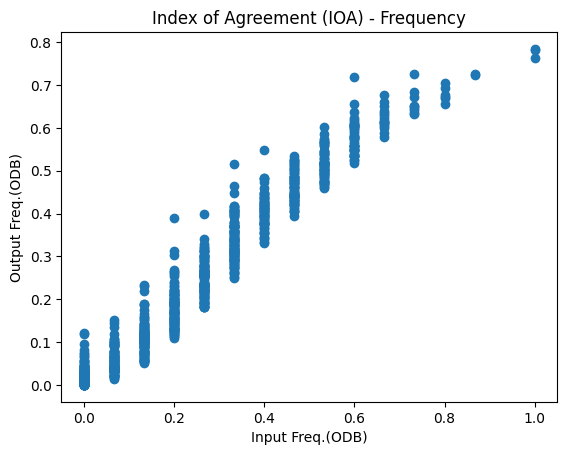

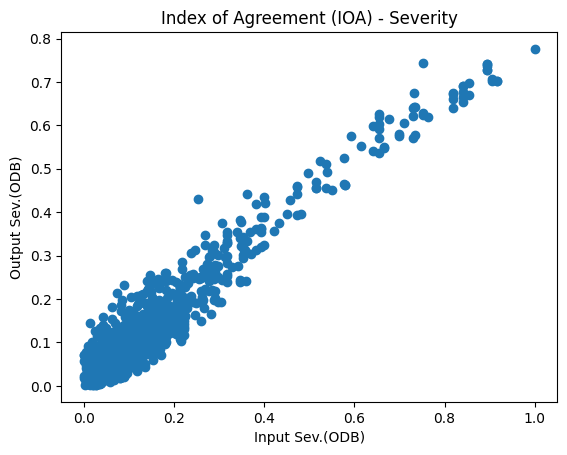

In [ ]:
#Autoencoder Latent Last Layer
W0=np.array(model.layers[0].get_weights()[0])
W1=np.array(model.layers[2].get_weights()[0])
W2=np.array(model.layers[4].get_weights()[0])
W3=np.array(model.layers[6].get_weights()[0])
WCC=((W0@W1)@W2)

#Credibility Array
XDT=XD@WCC

#Configuration of output weights
NIT=1000
WLL=np.random.rand(25,4)/100;
ek2=np.zeros((NIT,1)); ys=np.zeros((1000,4))
Beta=2

for i1 in range(NIT):
  ek2[i1,]=0
  for k in range(len(XDT)):
    ys[k,]=XDT[k,]@WLL
    ys[k,]=(1/(1+(np.power(ys[k,],-Beta))))
    ek=np.array(XD[k,]-ys[k,])
    ek2[i1,]=ek2[i1,]+np.sum(ek**2)
    WLL=WLL+0.0001*(XDT[k,].reshape(25,1)@(ek*((Beta)*np.power(ys[k,],-Beta-1))/(1+np.power(ys[k,],-Beta))**2).reshape(1,4))
    #WLL=WLL+0.0001*(XDT[k,].reshape(25,1)@ek.reshape(1,4))

print("Last Learning mse-error")
print(i1,ek2[i1,])

#Saving the Data and Resultws
dfio=pd.DataFrame(np.column_stack((XD,ys)))
print("Index of Agreement Array Input-Ouput Variables")
print(dfio.corr())
dfio.to_excel("Autoencoder_io.xlsx")

plt.figure()
plt.xlabel('Input Freq.(ODB)')
plt.ylabel('Output Freq.(ODB)')
plt.title('Index of Agreement (IOA) - Frequency')
plt.scatter(XD[:,0],ys[:,0])
plt.show()

plt.figure()
plt.xlabel('Input Sev.(ODB)')
plt.ylabel('Output Sev.(ODB)')
plt.title('Index of Agreement (IOA) - Severity')
plt.scatter(XD[:,1],ys[:,1])
plt.show()
